In [6]:
!rm -r images
!rm -r masks

In [7]:
%load_ext autoreload
%autoreload 2

import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader
import albumentations as A

from Dataset import BuildDatasetParts
from config import CFG
from scripts.Models.utils import set_seed
from scripts.Models.Metrics import dice_coef, iou_coef
from scripts.Models.ModelBuilder import ModelBuilder
from scripts.Models.Trainer import Trainer

In [8]:
def prepare_loaders():
    print("Video processing....")

    print("*********  Creating datasets  *********")
    train_dataset = BuildDatasetParts(data_transforms["train"], CFG)
    valid_dataset = BuildDatasetParts(data_transforms["valid"], CFG)
    print("*********  Creating datasets DONE  *********")

    print("********* Creating data loaders *********")
    train_dataloader = DataLoader(train_dataset, batch_size=CFG.train_bs,
                                  num_workers=2, shuffle=True, pin_memory=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=CFG.train_bs,
                                  num_workers=2, pin_memory=True)
    print("********* Creating data loaders DONE *********")

    return train_dataset, valid_dataset, train_dataloader, valid_dataloader

In [9]:
set_seed()

In [10]:
data_transforms = {
    "train": A.Compose([
                        A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5),
                        # A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
                        A.augmentations.transforms.PadIfNeeded(CFG.img_size[0], CFG.img_size[1],
                                                               position = A.transforms.PadIfNeeded.PositionType.BOTTOM_RIGHT,
                                                               border_mode = cv2.BORDER_CONSTANT,
                                                               value=0, mask_value=0),
                        A.Normalize()
                        ], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.Normalize()
        ], p=1.0)
}

In [11]:
train_dataset, valid_dataset, train_dataloader, valid_dataloader = prepare_loaders()

Video processing....
*********  Creating datasets  *********
*********  Creating datasets DONE  *********
********* Creating data loaders *********
********* Creating data loaders DONE *********


In [12]:
imgs, msks = next(iter(train_dataloader))
imgs.size(), msks.size()

(torch.Size([16, 1, 448, 448]), torch.Size([16, 6, 448, 448]))

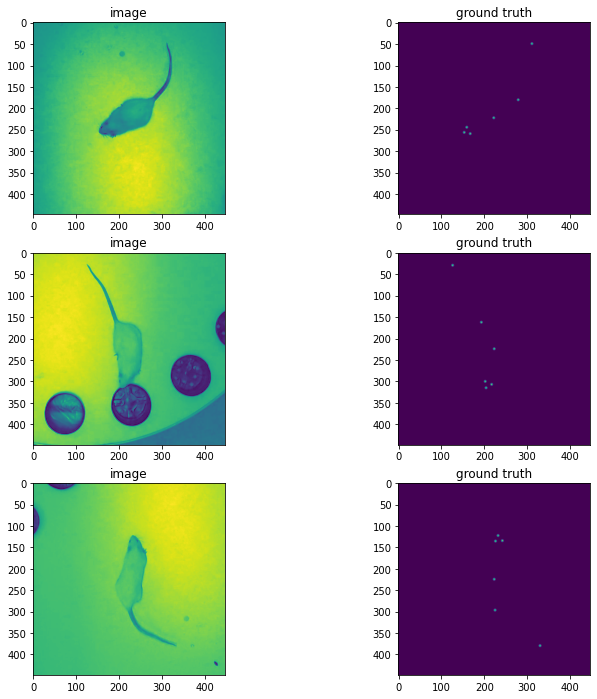

In [13]:
fig = plt.figure(figsize=(12, 12))
for i in range(1, 6, 2):
    ax1 = fig.add_subplot(3, 2, i)
    ax1.imshow(imgs[i][0])
    ax1.set_title("image")

    ax2 = fig.add_subplot(3, 2, i+1)
    ax2.imshow(torch.max(msks[i], dim=0).values)
    ax2.set_title("ground truth")

In [14]:
loss_fn = nn.MSELoss()
dice_loss = dice_coef
iou_loss  = iou_coef

In [15]:
model_builder = ModelBuilder(1, 6, CFG, pretrained_model_path=None)

model_pytorch = model_builder.get_model()

optimizer = optim.Adam(model_pytorch.parameters(), lr=CFG.lr)

# Run Training

In [16]:
model_trainer = Trainer(model_pytorch, train_dataloader, valid_dataloader, optimizer, loss_fn, dice_loss, iou_loss, CFG)

In [3]:
model_trainer.run_training()

# Result

In [4]:
test_dataset = BuildDatasetParts(data_transforms["valid"], CFG.img_size[0])
test_loader = DataLoader(test_dataset, batch_size=3, num_workers=2, pin_memory=True)

imgs, msks = next(iter(test_loader))
imgs = imgs.to(CFG.device, dtype=torch.float)

preds = []
with torch.no_grad():
    pred = model_pytorch(imgs)
preds.append(pred)

imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

In [5]:
i = 1
fig = plt.figure(figsize=(12, 12))
for img, msk, pred in zip(imgs, msks, preds):
    ax1 = fig.add_subplot(3, 3, i)
    ax1.imshow(img[0])
    ax1.set_title("image")

    ax2 = fig.add_subplot(3, 3, i+1)
    ax2.imshow(msk[0])
    ax2.set_title("ground truth")

    ax3 = fig.add_subplot(3, 3, i+2)
    ax3.imshow(pred[0])
    ax3.set_title("predicted")
    i+= 3